In [3]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx

%matplotlib inline

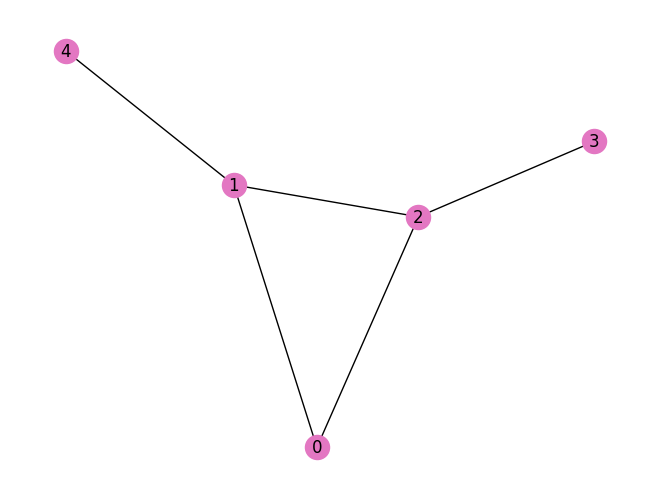

In [21]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)]
graph = nx.Graph(edges)
nx.draw(graph, with_labels=True, node_color="#e377c2")

In [6]:
cost_h, driver_h = qaoa.max_clique(graph, constrained=False)

print("Cost Hamiltonian: ")
print(cost_h)
print()
print("Driver Hamiltonian: ")
print(driver_h)

Cost Hamiltonian: 
  (-1.25) [Z3]
+ (-1.25) [Z4]
+ (-0.5) [Z0]
+ (0.25) [Z1]
+ (0.25) [Z2]
+ (0.75) [Z0 Z3]
+ (0.75) [Z0 Z4]
+ (0.75) [Z1 Z3]
+ (0.75) [Z2 Z4]
+ (0.75) [Z3 Z4]

Driver Hamiltonian: 
  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]


In [9]:
def build_commutator(graph):
    H = qml.Hamiltonian([], [])

    # Computes the complement of the graph
    graph_c = nx.complement(graph)

    for k in graph_c.nodes:
        # Adds the terms in the first sum
        for edge in graph_c.edges:
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) @ qml.PauliZ(j) - qml.PauliY(k))
            if k == j:
                H += 6 * (qml.PauliZ(i) @ qml.PauliY(k) - qml.PauliY(k))
        # Adds the terms in the second sum
        H += 6 * qml.PauliY(k)

    return H


print("MaxClique Commutator: ")
print(build_commutator(graph))

MaxClique Commutator: 
  (-12.0) [Y3]
+ (-12.0) [Y4]
+ (-6.0) [Y0]
+ (6.0) [Y0 Z3]
+ (6.0) [Y0 Z4]
+ (6.0) [Y1 Z3]
+ (6.0) [Y2 Z4]
+ (6.0) [Z0 Y3]
+ (6.0) [Z1 Y3]
+ (6.0) [Y3 Z4]
+ (6.0) [Z0 Y4]
+ (6.0) [Z2 Y4]
+ (6.0) [Z3 Y4]


In [10]:
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, delta_t * beta_k, 1)

In [11]:
def build_maxclique_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz


def expval_circuit(beta, measurement_h):
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

Finally, we implement the recursive process, where FALQON is able to
determine the values of $\beta_k$, feeding back into itself as the
number of layers increases. This is straightforward using the methods
defined above:


In [15]:
def max_clique_falqon(graph, n, beta_1, delta_t, dev):
    comm_h = build_commutator(graph) # Builds the commutator
    cost_h, driver_h = qaoa.max_clique(graph, constrained=False) # Builds H_c and H_d
    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd") # The ansatz + measurement circuit is executable

    beta = [beta_1] # Records each value of beta_k
    energies = [] # Records the value of the cost function at each step

    for i in range(n):
        # Adds a value of beta to the list and evaluates the cost function
        beta.append(-1 * cost_fn(beta, measurement_h=comm_h))  # this call measures the expectation of the commuter hamiltonian
        energy = cost_fn(beta, measurement_h=cost_h)  # this call measures the expectation of the cost hamiltonian
        energies.append(energy)

    return beta, energies

It is important that we
choose $\Delta t$ small enough such that the approximate time evolution
is close enough to the real time evolution, otherwise we the expectation
value of $H_c$ may not strictly decrease. For this demonstration, we set
$\Delta t = 0.03$, $n = 40$, and $\beta_1 = 0$. These are comparable to
the hyperparameters chosen in the original paper.


In [39]:
n = 40
beta_1 = 0.0
delta_t = 0.03

dev = qml.device("default.qubit", wires=graph.nodes) # Creates a device for the simulation
res_beta, res_energies = max_clique_falqon(graph, n, beta_1, delta_t, dev)

We can then plot the expectation value of the cost Hamiltonian over the
iterations of the algorithm:


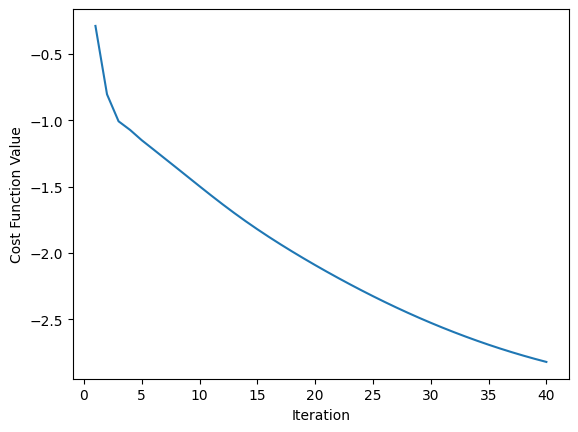

In [40]:
plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()

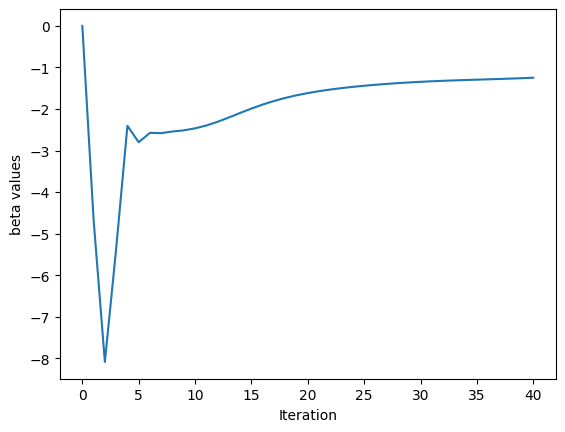

In [41]:
plt.plot(range(n+1), res_beta)
plt.xlabel("Iteration")
plt.ylabel("beta values")
plt.show()

The expectation value decreases!

To get a better understanding of the performance of the FALQON
algorithm, we can create a graph showing the probability of measuring
each possible bit string. We define the following circuit, feeding in
the optimal values of $\beta_k$:


In [18]:
@qml.qnode(dev, interface="autograd")
def prob_circuit():
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(res_beta)
    return qml.probs(wires=dev.wires)

Running this circuit gives us the following probability distribution:


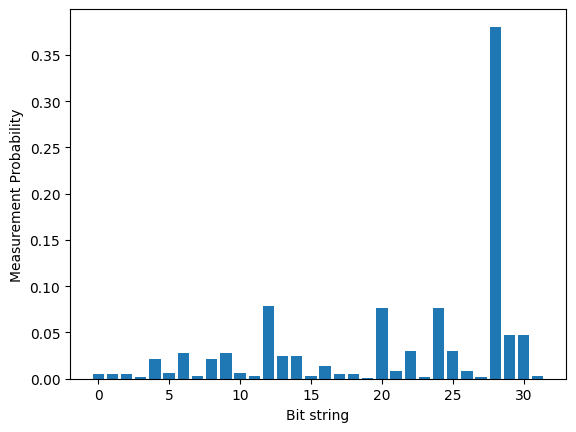

In [19]:
probs = prob_circuit()
plt.bar(range(2**len(dev.wires)), probs)
plt.xlabel("Bit string")
plt.ylabel("Measurement Probability")
plt.show()

The bit string occurring with the highest probability is the state
$|28\rangle = |11100\rangle$. This corresponds to nodes $0$, $1$, and
$2$, which is precisely the maximum clique. FALQON has solved the
MaxClique problem.


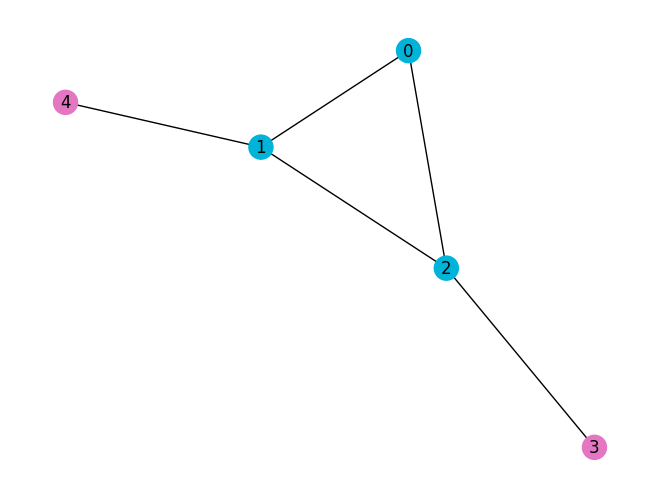

In [37]:
graph = nx.Graph(edges)
cmap = ["#00b4d9"]*3 + ["#e377c2"]*2
nx.draw(graph, with_labels=True, node_color=cmap)

## Seeding QAOA with FALQON (Bird Seed)

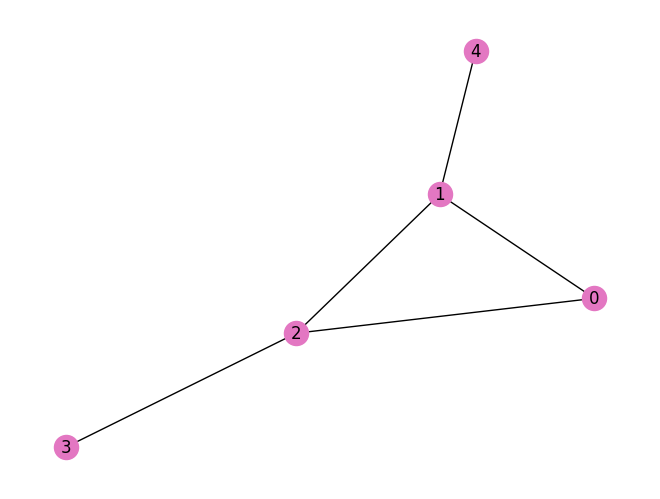

In [32]:
new_edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)]
new_graph = nx.Graph(new_edges)
nx.draw(new_graph, with_labels=True, node_color="#e377c2")

We can now use the PennyLane QAOA module to create a QAOA circuit
corresponding to the MaxClique problem. For this demonstration, we set
the depth to $5$:


In [33]:
depth = 5
dev = qml.device("default.qubit", wires=new_graph.nodes)

# Creates the cost and mixer Hamiltonians
cost_h, mixer_h = qaoa.max_clique(new_graph, constrained=False)

# Creates a layer of QAOA
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(beta, mixer_h)

# Creates the full QAOA circuit as an executable cost function
def qaoa_circuit(params, **kwargs):
    for w in dev.wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])


@qml.qnode(dev, interface="autograd")
def qaoa_expval(params):
    qaoa_circuit(params)
    return qml.expval(cost_h)

Now all we have to do is run FALQON for $5$ steps to get our initial
QAOA parameters. We set $\Delta t = 0.02$:


In [34]:
delta_t = 0.02

res, res_energy = max_clique_falqon(new_graph, depth-1, 0.0, delta_t, dev)

params = np.array([[delta_t for k in res], [delta_t * k for k in res]], requires_grad=True)

Finally, we run our QAOA optimization procedure. We set the number of
QAOA executions to $40$:


In [35]:
steps = 40

optimizer = qml.GradientDescentOptimizer()

for s in range(steps):
    params, cost = optimizer.step_and_cost(qaoa_expval, params)
    print("Step {}, Cost = {}".format(s + 1, cost))

Step 1, Cost = -0.8527486435590181
Step 2, Cost = -2.0996441082686275
Step 3, Cost = -2.146938027306
Step 4, Cost = -2.1794975389255664
Step 5, Cost = -2.2140404487752803
Step 6, Cost = -2.2524810539674984
Step 7, Cost = -2.2957717830317175
Step 8, Cost = -2.344777990403004
Step 9, Cost = -2.4002462118162953
Step 10, Cost = -2.4626058336428107
Step 11, Cost = -2.531693416846135
Step 12, Cost = -2.60650337717947
Step 13, Cost = -2.6851306695509187
Step 14, Cost = -2.7650399785012256
Step 15, Cost = -2.8436212707765054
Step 16, Cost = -2.9187908306862003
Step 17, Cost = -2.98936066278601
Step 18, Cost = -3.0550575805216478
Step 19, Cost = -3.1162690257429255
Step 20, Cost = -3.173680880327872
Step 21, Cost = -3.227947616898252
Step 22, Cost = -3.279474707961248
Step 23, Cost = -3.328351529200457
Step 24, Cost = -3.374442350029903
Step 25, Cost = -3.417591557579685
Step 26, Cost = -3.45783528221025
Step 27, Cost = -3.4954989840447834
Step 28, Cost = -3.531138849402102
Step 29, Cost = -3.5

To conclude, we can check how well FALQON/QAOA solved the optimization
problem. We define a circuit which outputs the probabilities of
measuring each bit string, and create a bar graph:


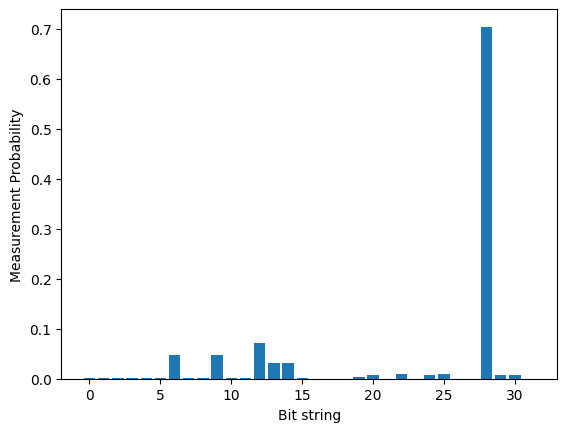

In [36]:
@qml.qnode(dev, interface="autograd")
def prob_circuit(params):
    qaoa_circuit(params)
    return qml.probs(wires=dev.wires)

probs = prob_circuit(params)
plt.bar(range(2**len(dev.wires)), probs)
plt.xlabel("Bit string")
plt.ylabel("Measurement Probability")
plt.show()